In [1]:
%load_ext watermark
%watermark -p tensorflow,numpy -v -m

CPython 3.6.2
IPython 6.1.0

tensorflow 1.0.0
numpy 1.13.3

compiler   : GCC 4.2.1 (Apple Inc. build 5666) (dot 3)
system     : Darwin
release    : 17.3.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [36]:
import codecs
import jieba
import nltk
import numpy as np
import tensorflow as tf
from collections import Counter
import time
import matplotlib.pyplot as plt 

from tensorflow.contrib.legacy_seq2seq import basic_rnn_seq2seq, embedding_rnn_seq2seq, sequence_loss
from tensorflow.python.ops import variable_scope
%matplotlib inline

## 数据清洗

In [3]:
en_train_path = '../code/TED_en_train.txt'
zh_train_path = '../code/TED_zh_train.txt'
en_test_path = '../code/TED_en_test.txt'
zh_test_path = '../code/TED_zh_test.txt'

In [4]:
# 英文分词
def load_en_data(en_path):
    line_no = 0
    limits = 1000 # 限定读取大小
    en_data = []
    all_words = []
    with open(en_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f.readlines():
            line_no += 1
            if line_no >= limits:
                break
            words = nltk.tokenize.word_tokenize(line.strip())
            en_data.append(words)
            for word in words:
                all_words.append(word)
    return en_data,all_words

In [5]:
en_train_data,en_train_words = load_en_data(en_train_path)
en_test_data,en_test_words = load_en_data(en_test_path)

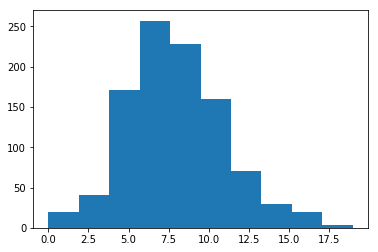

In [48]:
en_lengths = [len(s) for s in en_train_data] 
plt.hist(en_lengths);

In [6]:
# 中文分词
def load_zh_data(zh_path):
    zh_data = []
    all_words = []
    line_no = 0
    limits = 1000 # 限定读取大小
    with open(zh_path, 'r') as f:
        for line in f.readlines():
            line_no += 1
            if line_no >= limits:
                break
            words = [word for word in jieba.cut(line.strip())]
            zh_data.append(words)
            for word in words:
                all_words.append(word)
    return zh_data,all_words

In [7]:
zh_train_data,zh_train_words = load_zh_data(zh_train_path)
zh_test_data,zh_test_words = load_zh_data(zh_test_path)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/g5/df85rhb10jb9qpw1wdlh0t_m0000gn/T/jieba.cache
Loading model cost 0.929 seconds.
Prefix dict has been built succesfully.


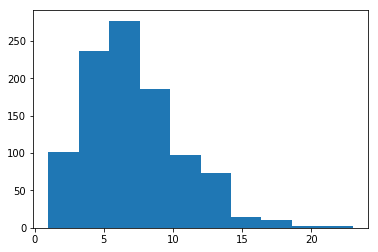

In [49]:
zh_lengths = [len(s) for s in zh_train_data] 
plt.hist(zh_lengths);

In [8]:
# 词表 Init
UNK = "<UNK>"  # 标记未出现在词汇表中的字符
PAD = "<PAD>"  
GO = "<GO>"    # 开始
EOS = "<EOS>"  # 结束
START_VOCABULART = [UNK, PAD, GO, EOS]
#vocab_size = 10000

In [11]:
# 构建英语词表，及将词标注 Index ，去掉词频小于 2 的词
en_vocab = []
for word,cnt in Counter(en_train_words).most_common():
    if cnt > 1:
        en_vocab.append(word)
    else:
        break
en_idx_dict = dict(zip(en_vocab, range(len(en_vocab))))

In [13]:
# 构建中文词表，及将词标注 Index，去掉词频小于 2 的词
zh_vocab = START_VOCABULART
for word,cnt in Counter(zh_train_words).most_common():
    if cnt > 1:
        zh_vocab.append(word)
    else:
        break
zh_idx_dict = dict(zip(zh_vocab, range(len(zh_vocab))))

In [15]:
# 得到词表大小
num_encoder_symbols = len(en_vocab)
num_decoder_symbols = len(zh_vocab)

In [16]:
# 为中文集增加 token
def get_token(data):
    zh_set = []
    for line in data:
        zh_set.append(['<GO>'] + line + ['<EOS>'])
    return zh_set

In [17]:
zh_train_set = get_token(zh_train_data)
zh_test_set = get_token(zh_test_data)

In [21]:
# 将句子转换为向量
def convert_to_vector(data, vocab, idx_dict):
    data_index = []
    for line in data:
        index_content = []
        for word in line:
            idx = idx_dict[word] if (word in vocab) else 0
            index_content.append(idx)
        data_index.append(index_content)
    return data_index

In [22]:
en_train_index = convert_to_vector(en_train_data, en_vocab, en_idx_dict)
zh_train_index = convert_to_vector(zh_train_set, zh_vocab, zh_idx_dict)

In [23]:
en_test_index = convert_to_vector(en_test_data, en_vocab, en_idx_dict)
zh_test_index = convert_to_vector(zh_test_set, zh_vocab, zh_idx_dict)

In [25]:
# 将数据分为不同的 buckets
_buckets = [(10, 10), (15, 15), (20, 20)]
def to_buckets(en_train_data, zh_train_set):
    data_set = [[] for _ in _buckets]
    for source, target in zip(en_train_data, zh_train_set):
        for bucket_id, (source_size, target_size) in enumerate(_buckets):
            if len(source) <= source_size and len(target) <= target_size:
                data_set[bucket_id].append([source, target])
                break
    return data_set

In [26]:
train_data_set = to_buckets(en_train_index, zh_train_index)
test_data_set = to_buckets(en_test_index, zh_test_index)

In [27]:
# 对数据完成 padding，encoder 在开头 padding，decoder 在结尾 padding
def get_padding(inputs, _buckets):
    PAD = 1 # idx of PAD
    data_set = [[] for _ in _buckets]
    for bucket_id, (source_size, target_size) in enumerate(_buckets):
        data = inputs[bucket_id]
        for source, target in data:
            new_source = [PAD] * (source_size - len(source)) + source
            new_target = target + [PAD] * (target_size - len(target))
            data_set[bucket_id].append([new_source, new_target])
    return data_set

In [28]:
train_data_padding = get_padding(train_data_set, _buckets)
test_data_padding = get_padding(test_data_set, _buckets)

In [29]:
data_sizes = [len(train_data_padding[i]) for i in range(len(_buckets))]

In [31]:
data_sizes

[660, 289, 46]

## 构建 seq2seq 模型

In [23]:
# 重置 graph
tf.reset_default_graph()

In [24]:
# 模型相关参数
cell_size = 128
embedding_size = 128
batch_size = 50

In [25]:
# 定义 GRU Cell
cell = tf.contrib.rnn.GRUCell(cell_size)

In [26]:
#取句子 padding 后的最大可能长度
max_encoder_length, max_decoder_length = _buckets[-1]

In [27]:
# placeholders init
encoder_placeholders = [
    tf.placeholder(tf.int32, shape=[None], name="encoder_%d" % i)
    for i in range(max_encoder_length)]
decoder_placeholders = [
    tf.placeholder(tf.int32, shape=[None], name="decoder_%d" % i)
    for i in range(max_decoder_length)]
target_placeholders = [
    tf.placeholder(tf.int32, shape=[None], name="target_%d" % i)
    for i in range(max_decoder_length)]
target_weights_placeholders = [
    tf.placeholder(tf.float32, shape=[None], name="decoder_weight_%d" % i)
    for i in range(max_decoder_length)]

In [29]:
num_samples = 256
w_t = tf.get_variable("proj_w", [num_decoder_symbols, batch_size], dtype=tf.float32)
w = tf.transpose(w_t)
b = tf.get_variable("proj_b", [num_decoder_symbols], dtype=tf.float32)
output_projection = (w, b)

def softmax_loss_function(labels, logits):
    labels = tf.reshape(labels, [-1, 1])
    # We need to compute the sampled_softmax_loss using 32bit floats to
    # avoid numerical instabilities.
    local_w_t = tf.cast(w_t, tf.float32)
    local_b = tf.cast(b, tf.float32)
    local_inputs = tf.cast(logits, tf.float32)
    return tf.cast(
        tf.nn.sampled_softmax_loss(
            weights=local_w_t,
            biases=local_b,
            labels=labels,
            inputs=local_inputs,
            num_sampled=num_samples,
            num_classes=num_decoder_symbols),
            dtype=tf.float32)

In [30]:
# 用于model_with_buckets模型的seq2seq参数
def seq2seq_f(encoder_inputs, decoder_inputs, do_decode):
    return embedding_rnn_seq2seq(
                        encoder_inputs, 
                        decoder_inputs, 
                        cell,
                        num_encoder_symbols, 
                        num_decoder_symbols,
                        embedding_size, 
                        output_projection=None,
                        feed_previous=False)

In [31]:
outputs, losses = tf.contrib.legacy_seq2seq.model_with_buckets(
        encoder_placeholders, decoder_placeholders, target_placeholders,
        target_weights_placeholders, _buckets, lambda x, y: seq2seq_f(x, y, False),
        softmax_loss_function=None)

## 准备 feed 数据

In [32]:
def left_shift(decoder_inputs):
    """generate targets grom decoder_inputs"""
    return [list(input_[1:]) + [_PAD_ID] for input_ in decoder_inputs]

def get_bucket_inputs(encoder_data, decoder_data, bucket_id):
    encoder_inputs = encoder_data[bucket_id]
    decoder_inputs = decoder_data[bucket_id]
    return (encoder_inputs, decoder_inputs)

def get_batch_inputs(encoder_data, decoder_data, bucket_id, batch_start, batch_size):
    encoder_inputs = encoder_data[bucket_id][batch_start : batch_start+batch_size]
    decoder_inputs = decoder_data[bucket_id][batch_start : batch_start+batch_size]
    return (encoder_inputs, decoder_inputs)

def generate_feed_dict(inputs_tuple, encoder_size, decoder_size):
    """对 inputs 做转置, 并喂给 placeholder 列表, 得到 feed_dict"""
    encoder_inputs, decoder_inputs = inputs_tuple
    encoder_inputs = list(zip(*encoder_inputs))
    target_inputs = list(zip(*left_shift(decoder_inputs)))
    decoder_inputs = list(zip(*decoder_inputs)) 
    
    feed_dict = dict()
    # Prepare input data
    for i in range(encoder_size):
        # 这里用 placeholder 或者 placeholder.name 都可以
        feed_dict[encoder_placeholders[i].name] = np.asarray(encoder_inputs[i], dtype=int)
    for i in range(decoder_size):
        feed_dict[decoder_placeholders[i].name] = np.asarray(decoder_inputs[i], dtype=int)
        feed_dict[target_placeholders[i].name] = np.asarray(target_inputs[i], dtype=int)        
        # 这里使用 weights 把 <PAD> 的损失屏蔽了
        feed_dict[target_weights_placeholders[i].name] = np.asarray(
            [float(idx != _PAD_ID) for idx in target_inputs[i]], dtype=float)
    return feed_dict

## 训练模型

In [33]:
# 训练相关参数
epochs = 500
print_loss_every = 5
learning_rate = 3
batch_size = 50

In [35]:
# 把不同 bucket 的 loss 分别传给 optimizer, 得到不同的 train_step. 不知可否?
train_steps = [tf.train.AdagradOptimizer(learning_rate).minimize(losses[i]) 
               for i in range(len(_buckets))]

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [36]:
# Training
start_time = time.time()
try:
    print('Epoch ' + ''.join(['bucket-{} '.format(i) for i in range(len(_buckets))]))
    for i in range(epochs):
        if i % print_loss_every == 0:
            print('\n{: 4d}'.format(i), end=' ')

        for bucket_id in range(len(_buckets)):
            cur_data_size = data_sizes[bucket_id]
            if cur_data_size == 0:
                continue  # 某个 bucket 为空的特殊情形
            encoder_size, decoder_size = _buckets[bucket_id]
            
            # 输出 loss 过程信息
            if i % print_loss_every == 0:
                bucket_inputs = get_bucket_inputs(encoder_data, decoder_data, bucket_id)
                bucket_feed = generate_feed_dict(bucket_inputs, encoder_size, decoder_size)
                loss_val = sess.run(losses[bucket_id], feed_dict=bucket_feed)
                print('{: 8.4f}'.format(loss_val), end=' ')
            
            # 训练
            for batch_start in range(0, cur_data_size, batch_size):
                batch_inputs = get_batch_inputs(
                    encoder_data, decoder_data, bucket_id, batch_start, batch_size)
                batch_feed = generate_feed_dict(batch_inputs, encoder_size, decoder_size)
                sess.run(train_steps[bucket_id], feed_dict=batch_feed)
except KeyboardInterrupt:
    print('\nKeyboardInterrup')

print('Train time: {} s'.format(time.time() - start_time))

Epoch bucket-0 bucket-1 bucket-2 

   0 

NameError: name 'encoder_data' is not defined